In [1]:
!pip install transformers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd # to play audio in the notebook
import sys
import warnings
from sklearn.model_selection import train_test_split

import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

import cv2
from scipy.io import wavfile

from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer

from PIL import Image
import torch.optim as optim

import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [2]:
RAV = "/content/drive/MyDrive/Colab Notebooks/Dataset/RAVDESS/"
dir_list = os.listdir(RAV)

In [3]:
#creating the meta-data of RAVDESS dataset
emotion = []
gender = []
path = []

for i in dir_list:
    fname = os.listdir(RAV+ i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = 0 #"female"
        else:
            temp = 1 #"male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion, columns=['emotion'])
#RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([RAV_df,pd.DataFrame(gender, columns = ['gender'])],axis=1)
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.head()

,emotion,gender,path
0,2,0,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,2,0,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,3,0,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,4,0,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,8,0,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [4]:
img_path=[]

In [5]:
# Define the output folder
output_folder = '/content/ravdess_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to convert audio to Mel spectrogram and save as an image
def convert_audio_to_spectrogram(audio_path, output_folder, index):
    # Load the audio file
    y, sr = librosa.load(audio_path)

    # Compute the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    spectrogram_image = librosa.power_to_db(S, ref=np.max)

    # Display the spectrogram (optional)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_image, fmax=8000)
    plt.axis('off')  # Turn off the axis

    # Save the spectrogram as an RGB image
    image_filename = f"{index}.png"
    image_path = os.path.join(output_folder, image_filename)
    img_path.append(image_path)
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0, format='png', dpi=100)
    plt.close()  # Close the figure to release memory

# Assuming 'RAV_df' is your DataFrame with 'path' column
for index, row in RAV_df.iterrows():
    audio_path = row['path']
    convert_audio_to_spectrogram(audio_path, output_folder, index)
print('All files converted')

All files converted


In [13]:
RAV_df[320:330]

,emotion,gender,path,img_path
320,6,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/320.png
321,3,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/321.png
322,2,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/322.png
323,4,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/323.png
324,3,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/324.png
325,2,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/325.png
326,6,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/326.png
327,5,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/327.png
328,4,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/328.png
329,3,1,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/ravdess_images/329.png


In [6]:
l2 = img_path
RAV_df = pd.concat([RAV_df,pd.DataFrame(l2, columns = ['img_path'])],axis=1)

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_data):
        self.input_data = input_data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.input_data)
    def get_images(self, idx):
      image_path = self.input_data.iloc[idx]['img_path']
      return self.transform(Image.open(image_path).convert('RGB'))

    def get_labels(self, idx):
      return self.input_data.iloc[idx]['emotion']

    def __getitem__(self, idx):
        image_path = self.input_data.iloc[idx]['img_path']
        label = self.input_data.iloc[idx]['emotion']
        image = self.transform(Image.open(image_path).convert('RGB'))  # Assuming you are working with images
        return image, label

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined ViTConfig and ViTModel classes
class ViT(nn.Module):
    def __init__(self, config=ViTConfig(), num_labels=9, model_checkpoint='google/vit-base-patch16-224-in21k'):
        super(ViT, self).__init__()
        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, x):
        x = self.vit(x)['last_hidden_state']
        x = self.dropout(x)
        output = self.classifier(x[:, 0, :])
        return output

# def plot_confusion_matrix(true_labels, predicted_labels, num_labels):
#     cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_labels)))
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt="g", xticklabels=list(range(num_labels)), yticklabels=list(range(num_labels)))
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title("Confusion Matrix")
#     plt.show()
def plot_confusion_matrix(true_labels, predicted_labels, num_labels):
    labels = list(range(num_labels))
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="g", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def print_classification_metrics(true_labels, predicted_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}')

def model_train(train_dataset, test_dataset, epochs, learning_rate, batch_size, num_labels=9):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Combine train and test datasets for cross-validation split
    all_data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

    # Define cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(skf.split(all_data, [all_data[i][1] for i in range(len(all_data))])):
        print(f"\nFold {fold + 1}/{skf.n_splits}")

        # Split data into train and test sets for this fold
        train_subset = torch.utils.data.Subset(all_data, train_index)
        test_subset = torch.utils.data.Subset(all_data, test_index)

        # Load model, loss function, and optimizer
        model = ViT(num_labels=num_labels).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Load batch image for training and testing
        train_dataloader = DataLoader(train_subset, num_workers=1, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_subset, num_workers=1, batch_size=batch_size)

        # Lists to store accuracy and loss values for plotting
        train_accuracies, test_accuracies = [], []
        train_losses, test_losses = [], []

        # Training loop
        for epoch in range(epochs):
            total_loss_train = 0.0
            total_correct_train = 0

            # Training
            model.train()
            for train_image, train_label in tqdm(train_dataloader):
                train_image, train_label = train_image.to(device), train_label.to(device)
                optimizer.zero_grad()
                output = model(train_image)
                loss = criterion(output, train_label)
                loss.backward()
                optimizer.step()
                total_loss_train += loss.item()
                total_correct_train += (output.argmax(1) == train_label).sum().item()

            train_accuracy = total_correct_train / len(train_subset)
            train_accuracies.append(train_accuracy)
            train_losses.append(total_loss_train / len(train_dataloader))

            # Evaluation on the test dataset
            total_correct_test = 0
            true_labels, predicted_labels = [], []

            model.eval()
            with torch.no_grad():
                for test_image, test_label in test_dataloader:
                    test_image, test_label = test_image.to(device), test_label.to(device)
                    output = model(test_image)
                    total_correct_test += (output.argmax(1) == test_label).sum().item()

                    true_labels.extend(test_label.cpu().numpy())
                    predicted_labels.extend(output.argmax(1).cpu().numpy())

            test_accuracy = total_correct_test / len(test_subset)
            test_accuracies.append(test_accuracy)
            test_losses.append(loss.item())

            print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataloader):.3f} | '
                  f'Training Accuracy: {train_accuracy:.3f} | Test Accuracy: {test_accuracy:.3f}')

            # Print confusion matrix
        print_classification_metrics(true_labels, predicted_labels)
        plot_confusion_matrix(true_labels, predicted_labels, num_labels)
        # Plot accuracy and loss graphs
        plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, fold)


def plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, fold):
    epochs = range(1, len(train_accuracies) + 1)

    # Plot accuracies
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_accuracies, label=f'Train Accuracy', color='blue')
    plt.plot(epochs, test_accuracies, label=f'Test Accuracy', color='orange')
    plt.title(f'Accuracy Over Epochs (Fold {fold + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot losses
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_losses, label=f'Train Loss', color='blue')
    plt.plot(epochs, test_losses, label=f'Test Loss', color='orange')
    plt.title(f'Loss Over Epochs (Fold {fold + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Hyperparameters
EPOCHS = 15
LEARNING_RATE = 0.00005
BATCH_SIZE = 8

# Assuming you have already defined your ImageDataset class
# Convert the DataFrames to your custom datasets
train_df, test_df = train_test_split(RAV_df, test_size=0.4, random_state=42)
train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

# Train the model with 5-fold cross-validation
trained_model = model_train(train_dataset, test_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)


Fold 1/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: ignored

# **G E N D E R**

In [10]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_data):
        self.input_data = input_data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.input_data)
    def get_images(self, idx):
      image_path = self.input_data.iloc[idx]['img_path']
      return self.transform(Image.open(image_path).convert('RGB'))

    def get_labels(self, idx):
      return self.input_data.iloc[idx]['gender']

    def __getitem__(self, idx):
        image_path = self.input_data.iloc[idx]['img_path']
        label = self.input_data.iloc[idx]['gender']
        image = self.transform(Image.open(image_path).convert('RGB'))  # Assuming you are working with images
        return image, label


Fold 1/5


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 144/144 [00:38<00:00,  3.70it/s]


Epochs: 1 | Loss: 0.272 | Training Accuracy: 0.877 | Test Accuracy: 0.972


100%|██████████| 144/144 [00:39<00:00,  3.68it/s]


Epochs: 2 | Loss: 0.137 | Training Accuracy: 0.966 | Test Accuracy: 0.965


100%|██████████| 144/144 [00:40<00:00,  3.52it/s]


Epochs: 3 | Loss: 0.110 | Training Accuracy: 0.968 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 4 | Loss: 0.035 | Training Accuracy: 0.987 | Test Accuracy: 0.993


100%|██████████| 144/144 [00:40<00:00,  3.52it/s]


Epochs: 5 | Loss: 0.015 | Training Accuracy: 0.997 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 6 | Loss: 0.032 | Training Accuracy: 0.992 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 7 | Loss: 0.020 | Training Accuracy: 0.995 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.51it/s]


Epochs: 8 | Loss: 0.008 | Training Accuracy: 0.998 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 9 | Loss: 0.037 | Training Accuracy: 0.988 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:40<00:00,  3.51it/s]


Epochs: 10 | Loss: 0.028 | Training Accuracy: 0.990 | Test Accuracy: 0.993
Precision: 0.993 | Recall: 0.993 | F1 Score: 0.993


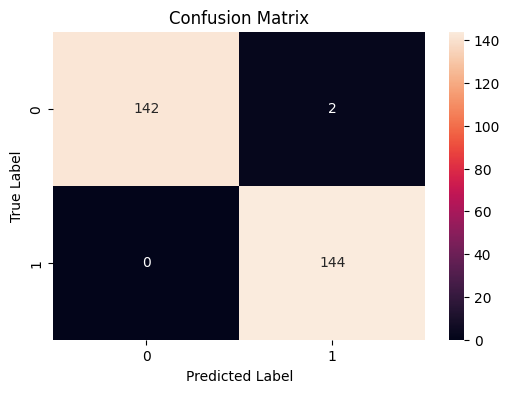

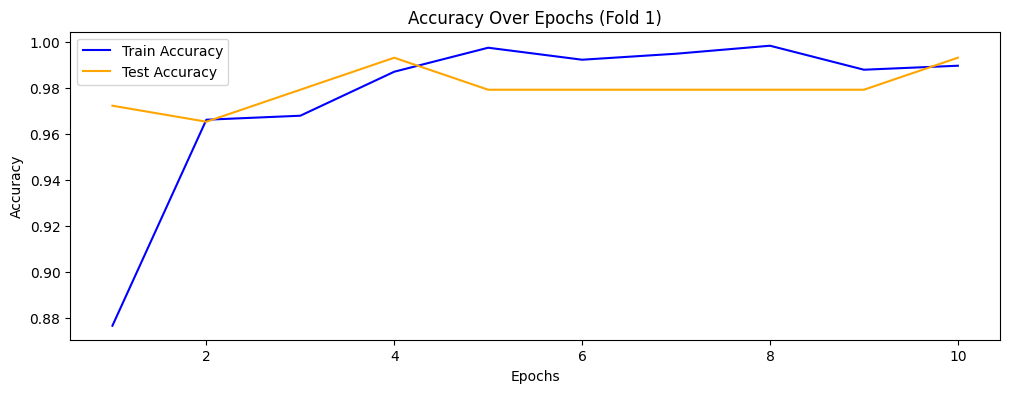

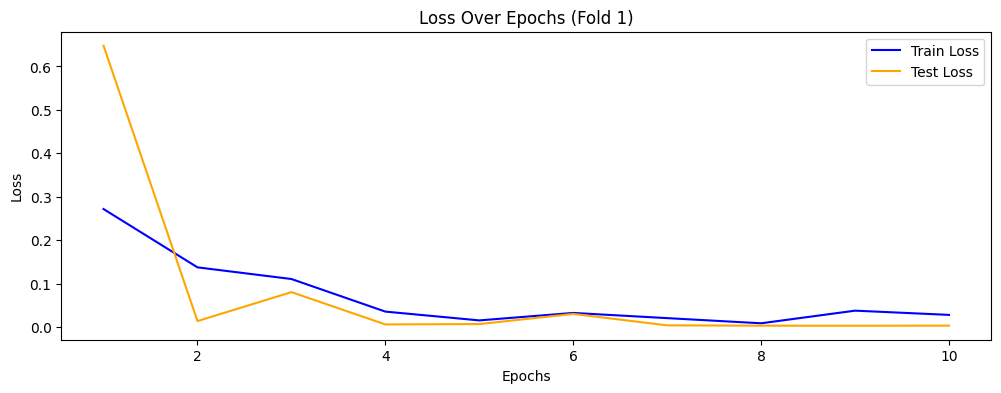


Fold 2/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 1 | Loss: 0.226 | Training Accuracy: 0.917 | Test Accuracy: 0.958


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 2 | Loss: 0.109 | Training Accuracy: 0.969 | Test Accuracy: 0.913


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 3 | Loss: 0.049 | Training Accuracy: 0.988 | Test Accuracy: 0.972


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 4 | Loss: 0.064 | Training Accuracy: 0.982 | Test Accuracy: 0.990


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 5 | Loss: 0.032 | Training Accuracy: 0.995 | Test Accuracy: 0.872


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 6 | Loss: 0.034 | Training Accuracy: 0.990 | Test Accuracy: 0.990


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 7 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.993


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 8 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.993


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 9 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.993


100%|██████████| 144/144 [00:41<00:00,  3.50it/s]


Epochs: 10 | Loss: 0.001 | Training Accuracy: 1.000 | Test Accuracy: 0.993
Precision: 0.993 | Recall: 0.993 | F1 Score: 0.993


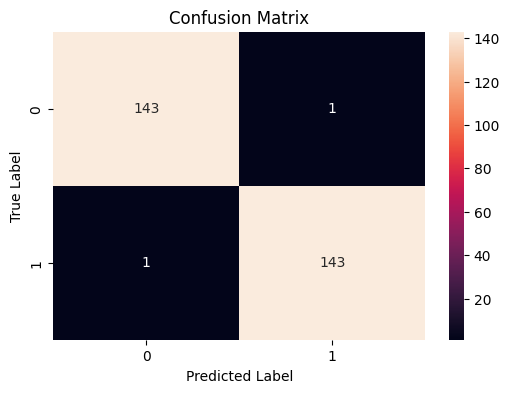

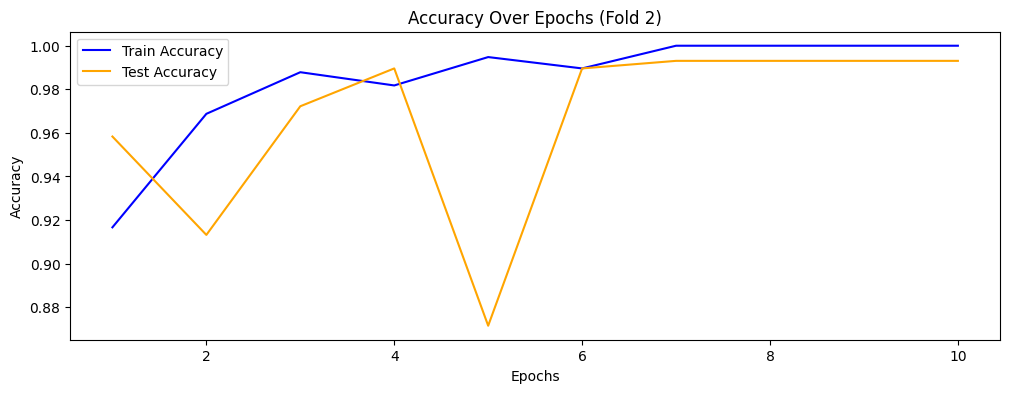

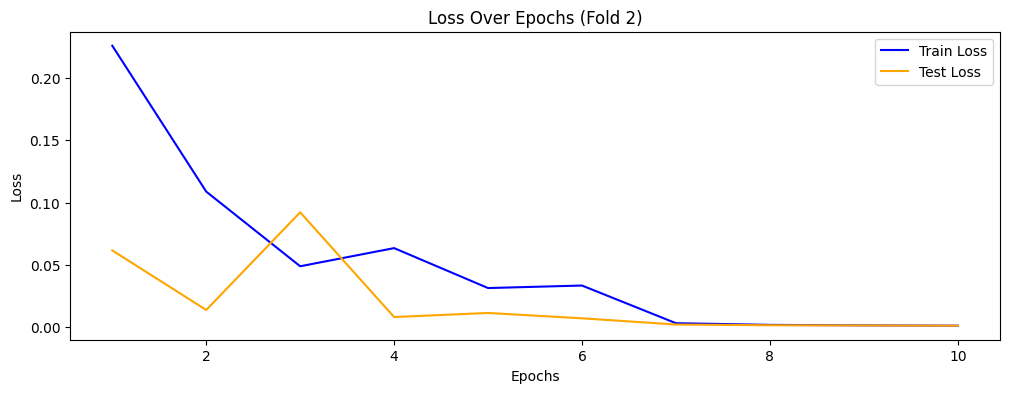


Fold 3/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 1 | Loss: 0.292 | Training Accuracy: 0.866 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 2 | Loss: 0.121 | Training Accuracy: 0.952 | Test Accuracy: 0.944


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 3 | Loss: 0.056 | Training Accuracy: 0.980 | Test Accuracy: 0.990


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 4 | Loss: 0.022 | Training Accuracy: 0.993 | Test Accuracy: 0.990


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 5 | Loss: 0.008 | Training Accuracy: 0.999 | Test Accuracy: 0.997


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 6 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.990


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 7 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.993


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 8 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.993


100%|██████████| 144/144 [00:41<00:00,  3.47it/s]


Epochs: 9 | Loss: 0.001 | Training Accuracy: 1.000 | Test Accuracy: 0.997


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 10 | Loss: 0.001 | Training Accuracy: 1.000 | Test Accuracy: 0.997
Precision: 0.997 | Recall: 0.997 | F1 Score: 0.997


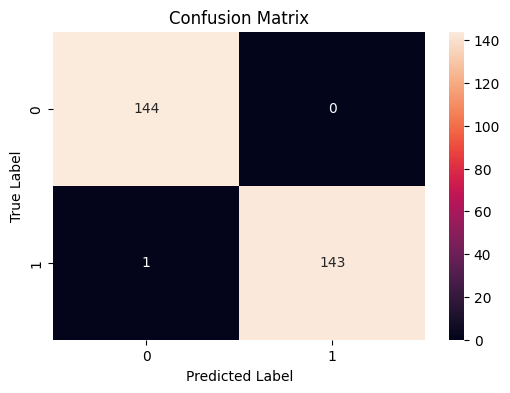

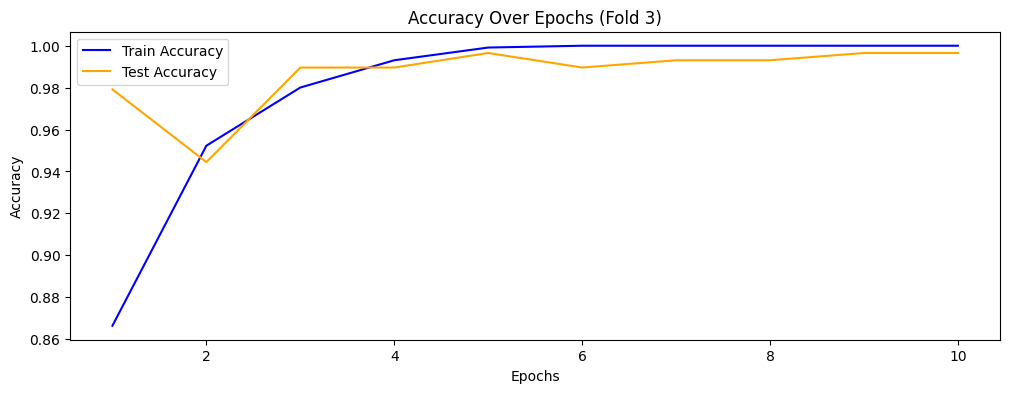

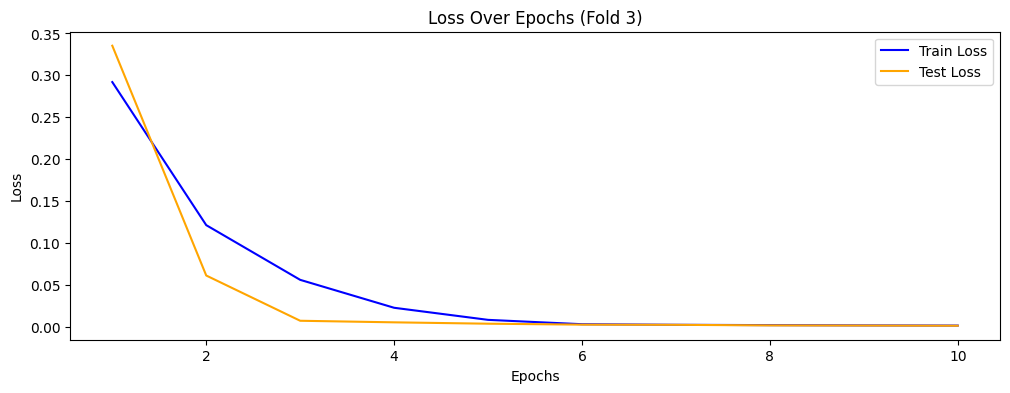


Fold 4/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 144/144 [00:41<00:00,  3.47it/s]


Epochs: 1 | Loss: 0.290 | Training Accuracy: 0.867 | Test Accuracy: 0.948


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 2 | Loss: 0.129 | Training Accuracy: 0.959 | Test Accuracy: 0.972


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 3 | Loss: 0.087 | Training Accuracy: 0.976 | Test Accuracy: 0.948


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 4 | Loss: 0.098 | Training Accuracy: 0.965 | Test Accuracy: 0.934


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 5 | Loss: 0.045 | Training Accuracy: 0.988 | Test Accuracy: 0.990


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 6 | Loss: 0.011 | Training Accuracy: 0.998 | Test Accuracy: 0.997


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 7 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.997


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 8 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.997


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 9 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.997


100%|██████████| 144/144 [00:41<00:00,  3.47it/s]


Epochs: 10 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.997
Precision: 0.997 | Recall: 0.997 | F1 Score: 0.997


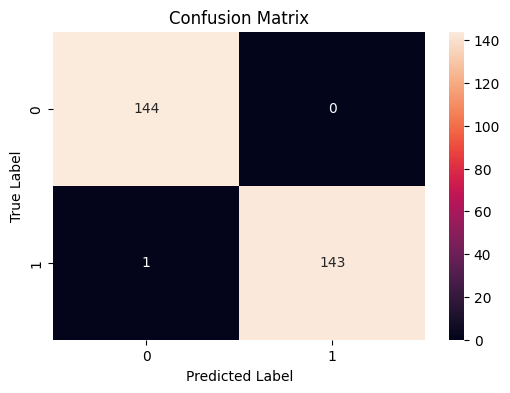

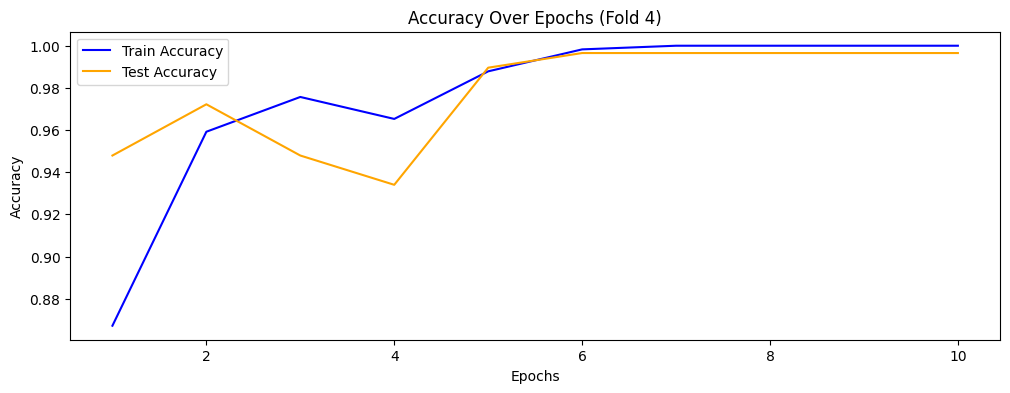

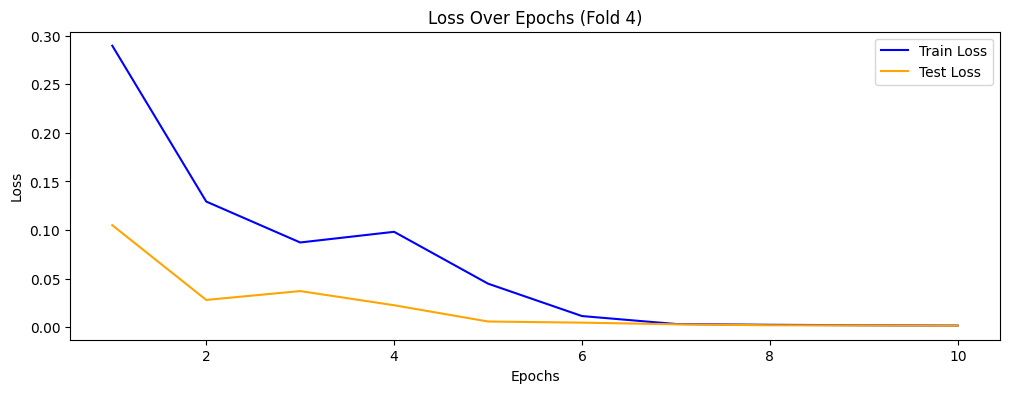


Fold 5/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 144/144 [00:41<00:00,  3.47it/s]


Epochs: 1 | Loss: 0.300 | Training Accuracy: 0.879 | Test Accuracy: 0.983


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 2 | Loss: 0.087 | Training Accuracy: 0.968 | Test Accuracy: 0.983


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 3 | Loss: 0.109 | Training Accuracy: 0.954 | Test Accuracy: 0.962


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 4 | Loss: 0.075 | Training Accuracy: 0.975 | Test Accuracy: 0.948


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 5 | Loss: 0.022 | Training Accuracy: 0.994 | Test Accuracy: 0.976


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 6 | Loss: 0.016 | Training Accuracy: 0.995 | Test Accuracy: 0.983


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 7 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.976


100%|██████████| 144/144 [00:41<00:00,  3.49it/s]


Epochs: 8 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 9 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.979


100%|██████████| 144/144 [00:41<00:00,  3.48it/s]


Epochs: 10 | Loss: 0.001 | Training Accuracy: 1.000 | Test Accuracy: 0.979
Precision: 0.979 | Recall: 0.979 | F1 Score: 0.979


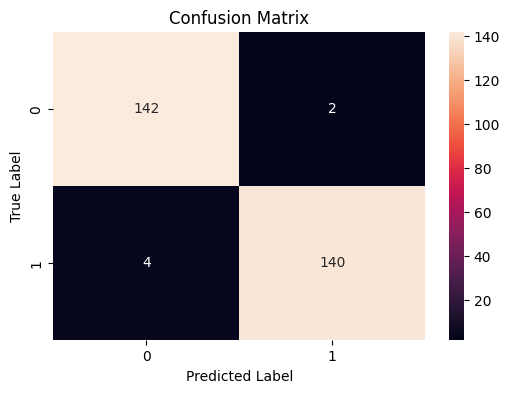

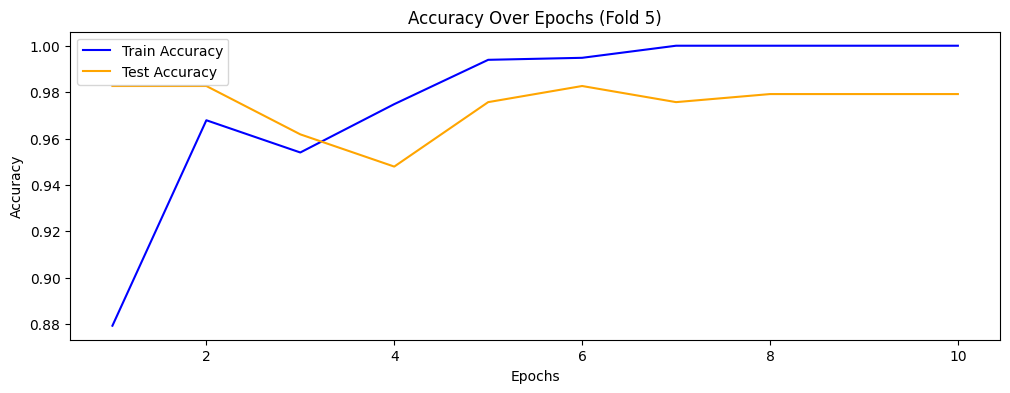

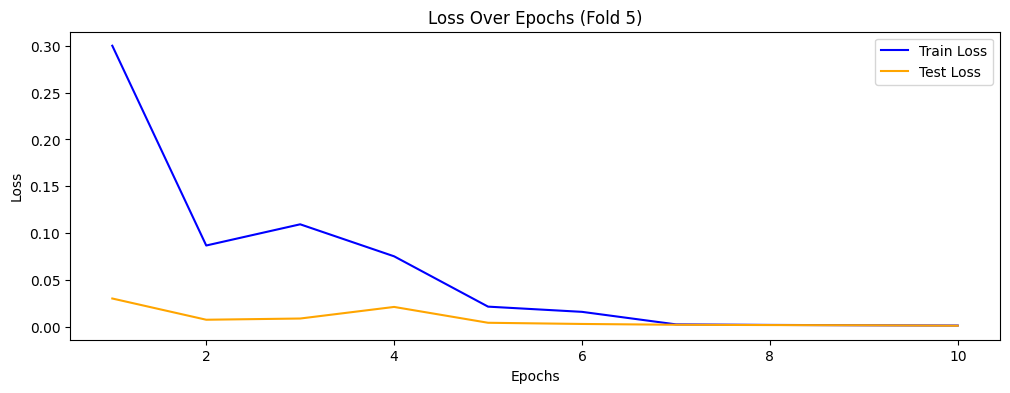

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined ViTConfig and ViTModel classes
class ViT(nn.Module):
    def __init__(self, config=ViTConfig(), num_labels=2, model_checkpoint='google/vit-base-patch16-224-in21k'):
        super(ViT, self).__init__()
        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, x):
        x = self.vit(x)['last_hidden_state']
        x = self.dropout(x)
        output = self.classifier(x[:, 0, :])
        return output

def plot_confusion_matrix(true_labels, predicted_labels, num_labels):
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_labels)))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="g", xticklabels=list(range(num_labels)), yticklabels=list(range(num_labels)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def print_classification_metrics(true_labels, predicted_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}')

def model_train(train_dataset, test_dataset, epochs, learning_rate, batch_size, num_labels=2  ):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Combine train and test datasets for cross-validation split
    all_data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

    # Define cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(skf.split(all_data, [all_data[i][1] for i in range(len(all_data))])):
        print(f"\nFold {fold + 1}/{skf.n_splits}")

        # Split data into train and test sets for this fold
        train_subset = torch.utils.data.Subset(all_data, train_index)
        test_subset = torch.utils.data.Subset(all_data, test_index)

        # Load model, loss function, and optimizer
        model = ViT(num_labels=num_labels).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Load batch image for training and testing
        train_dataloader = DataLoader(train_subset, num_workers=1, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_subset, num_workers=1, batch_size=batch_size)

        # Lists to store accuracy and loss values for plotting
        train_accuracies, test_accuracies = [], []
        train_losses, test_losses = [], []

        # Training loop
        for epoch in range(epochs):
            total_loss_train = 0.0
            total_correct_train = 0

            # Training
            model.train()
            for train_image, train_label in tqdm(train_dataloader):
                train_image, train_label = train_image.to(device), train_label.to(device)
                optimizer.zero_grad()
                output = model(train_image)
                loss = criterion(output, train_label)
                loss.backward()
                optimizer.step()
                total_loss_train += loss.item()
                total_correct_train += (output.argmax(1) == train_label).sum().item()

            train_accuracy = total_correct_train / len(train_subset)
            train_accuracies.append(train_accuracy)
            train_losses.append(total_loss_train / len(train_dataloader))

            # Evaluation on the test dataset
            total_correct_test = 0
            true_labels, predicted_labels = [], []

            model.eval()
            with torch.no_grad():
                for test_image, test_label in test_dataloader:
                    test_image, test_label = test_image.to(device), test_label.to(device)
                    output = model(test_image)
                    total_correct_test += (output.argmax(1) == test_label).sum().item()

                    true_labels.extend(test_label.cpu().numpy())
                    predicted_labels.extend(output.argmax(1).cpu().numpy())

            test_accuracy = total_correct_test / len(test_subset)
            test_accuracies.append(test_accuracy)
            test_losses.append(loss.item())

            print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataloader):.3f} | '
                  f'Training Accuracy: {train_accuracy:.3f} | Test Accuracy: {test_accuracy:.3f}')

            # Print confusion matrix
        print_classification_metrics(true_labels, predicted_labels)
        plot_confusion_matrix(true_labels, predicted_labels, num_labels)
        # Plot accuracy and loss graphs
        plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, fold)


def plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, fold):
    epochs = range(1, len(train_accuracies) + 1)

    # Plot accuracies
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_accuracies, label=f'Train Accuracy', color='blue')
    plt.plot(epochs, test_accuracies, label=f'Test Accuracy', color='orange')
    plt.title(f'Accuracy Over Epochs (Fold {fold + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot losses
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_losses, label=f'Train Loss', color='blue')
    plt.plot(epochs, test_losses, label=f'Test Loss', color='orange')
    plt.title(f'Loss Over Epochs (Fold {fold + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.0001
BATCH_SIZE = 8

# Assuming you have already defined your ImageDataset class
# Convert the DataFrames to your custom datasets
train_df, test_df = train_test_split(RAV_df, test_size=0.4, random_state=42)
train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

# Train the model with 5-fold cross-validation
trained_model = model_train(train_dataset, test_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)